In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn

import planecrashinfo_light as pci

from sklearn.cluster import KMeans

from gensim import corpora, models, utils
from gensim.models import TfidfModel, LsiModel

import nltk
from nltk.corpus import stopwords

%matplotlib inline

# Raw data

In [2]:
df = pd.read_csv('data/data.csv')

# Clean(er) Data

In [3]:
df = pci.clean_database(df)
df.head()

,Time,Location,Operator,Route,AC_Type,Aboard,Fatalities,Ground,Summary,Origin,Destination,Fatalities_total,Location_Country,Accident_type
Date,,,,,,,,,,,,,,
1921-02-03,NaN,"Mendotta, Minnesota",US Aerial Mail Service,NaN,De Havilland DH-4,1 (passengers:0 crew:1),1 (passengers:0 crew:1),0.0,Shortly after takeoff from Minneapolis-World C...,NaN,NaN,1.0,USA,0
1921-02-09,NaN,"La Crosse, Wisconsin",US Aerial Mail Service,NaN,Junkers F-13,3 (passengers:0 crew:3),3 (passengers:0 crew:3),0.0,Crashed for unknown reasons. Both pilots and t...,NaN,NaN,3.0,USA,0
1921-02-15,NaN,Gibraltar,Aeropostale,NaN,Breguet 14,2 (passengers:0 crew:2),2 (passengers:0 crew:2),0.0,The mail fligh encountered poor weather condit...,NaN,NaN,2.0,Gibraltar,0
1921-02-22,NaN,"Elko, Nevada",US Aerial Mail Service,NaN,De Havilland DH-4,1 (passengers:0 crew:1),1 (passengers:0 crew:1),0.0,"Shortly after taking off, the aircraft stalled...",NaN,NaN,1.0,USA,0
1921-04-06,NaN,"Point Cook, Australia",Military - Royal Australian Air Force,NaN,Avro 504,2 (passengers:0 crew:0),2 (passengers:0 crew:0),0.0,"Shortly after taking off on a training flight,...",NaN,NaN,2.0,Australia,0


In [5]:
print('Total number of the data: {}'.format(df.shape[0]))
print('Number of the not empty summaries: {}'.format(df[df.Summary.isnull()].shape[0]))

Total number of the data: 5686
Number of the not empty summaries: 231


## Let's try to cluster summaries
We'll use Latent Dirichlet allocation (LDA). LDA is a topic model that generates topics based on word frequency from a set of documents. LDA is particularly useful for finding reasonably accurate mixtures of topics within a given document set.

In [6]:
# set data without summary as empty row
df.Summary.fillna('', inplace=True)

In [7]:
splitter = nltk.data.load('tokenizers/punkt/english.pickle')
tokenizer = nltk.tokenize.TreebankWordTokenizer()
stopset = set(stopwords.words('english'))

In [8]:
def text_to_words(text):
texts = [text_to_words(text) for text in df.Summary.values]    tokenized_sentences = []
    sentences = splitter.tokenize(text)
    for sentence in sentences:
        tokens = []
        # remove punctuation and stopwords
        for token in utils.tokenize(sentence, lowercase=True, deacc=True, errors="ignore"):
            if token not in stopset:                
                tokens.append(token)
                
        
        tokenized_sentences.extend(tokens)
        tokenized_sentences.extend([' '.join(bigram) for bigram in nltk.ngrams(tokens, 2)])

    return tokenized_sentences

In [9]:
texts = [text_to_words(text) for text in df.Summary.values]

In [10]:
# create dictionary
dictionary = corpora.Dictionary(texts)

In [11]:
# create documents corpus
corpus = [dictionary.doc2bow(text) for text in texts]

#### And next question is how many clusters do we have? So let's reduce number of the dimensions for visualization

In [12]:
tfidf = TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

We'll use module for Latent Semantic Analysis (aka Latent Semantic Indexing). It implements fast truncated SVD (Singular Value Decomposition)

In [13]:
# project to 2 dimensions for visualization
lsi_model = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)

In [14]:
# save coordinates
coords = []

for coord in lsi_model[corpus]:
    if len(coord) > 1:
        coords.append((coord[0][1], coord[1][1]))

In [15]:
max_clusters = 10
clusters_num = range(1, max_clusters + 1)
inertias = np.zeros(max_clusters)

In [16]:
for cluster_num in clusters_num:
    kmeans = KMeans(cluster_num).fit(coords)
    # "inertia_" is sum of distances of samples to their closest cluster center
    inertias[cluster_num - 1] = kmeans.inertia_

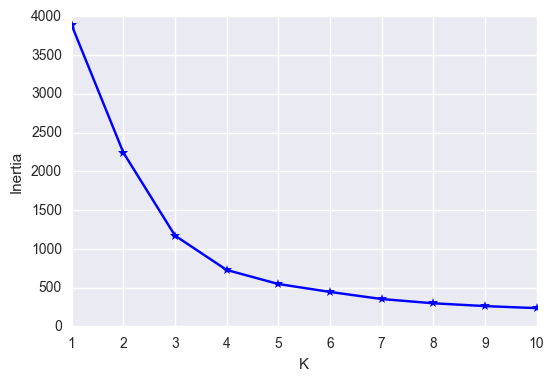

In [17]:
plt.plot(clusters_num, inertias, "b*-")

plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

In [20]:
# let's choose number of the clusters as 7
final_clusters_number = 7

kmeans = KMeans(final_clusters_number).fit(coords)

In [21]:
Counter(kmeans.labels_)

Counter({0: 1636, 1: 95, 2: 283, 3: 1801, 4: 474, 5: 994, 6: 172})

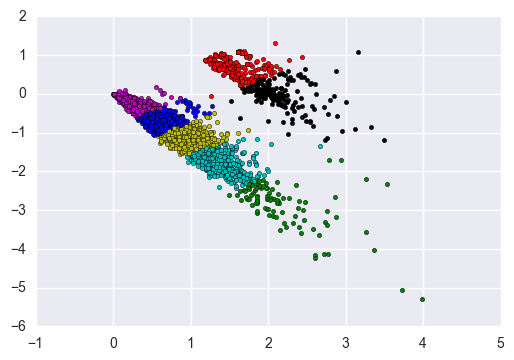

In [22]:
colors = ["b", "g", "r", "m", "c", "y", "k"]

for i in range(len(coords)):
    plt.scatter(coords[i][0], coords[i][1], c=colors[kmeans.labels_[i]], s=10)
    
plt.show()

#### Build LDA model with *num_topics = 7*

In [23]:
np.random.seed(42)

lda = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=final_clusters_number, passes=20)

In [24]:
lda.show_topics(final_clusters_number, num_words=10, formatted=False)

[(0,
  [('crashed taking', 0.00058215714204599826),
   ('mountains', 0.00052240055152475524),
   ('crashed mountains', 0.00048495604202086805),
   ('undershot', 0.00044098052967701671),
   ('undershot runway', 0.00040642654407357383),
   ('taking', 0.00040203507284784746),
   ('crashed', 0.00036179023195439597),
   ('training flight', 0.00035784945391406398),
   ('sandstorm', 0.00032198349345969007),
   ('double engine', 0.00031387558150468834)]),
 (1,
  [('takeoff', 0.0022587038558559802),
   ('engine', 0.001850374525202375),
   ('flight', 0.0018440109391168692),
   ('crashed takeoff', 0.0017330667957790797),
   ('failure', 0.0017173952899291749),
   ('weather', 0.0017061733543589806),
   ('pilot', 0.0016512408159040067),
   ('conditions', 0.0016454000703530918),
   ('crashed', 0.0016230672663270875),
   ('plane', 0.001583809696625835)]),
 (2,
  [('crashed approach', 0.0012241075794716173),
   ('approach', 0.0010130456769587063),
   ('runway', 0.00090340995204283658),
   ('overran run

In [25]:
# approximate names of the topics

summaries_topics = [
    'crashed into', 'crashed in route', 'structural failure', 'crashed landing', 
    'crashed takeoff', 'weather conditions', 'crashed shortly'
]

# Model interpretation

In [26]:
def compute_topic_summary_matrix(model, corpus, summaries):
    ts_matrix = pd.DataFrame(data=np.zeros((final_clusters_number, len(summaries))), columns=range(len(summaries)))
    
    for i, (summary, bow) in enumerate(zip(summaries, corpus)):
        summary_topics = model.get_document_topics(bow)
        
        for topic, prob in summary_topics:
            ts_matrix[i][topic] += prob
        
    return ts_matrix

([<matplotlib.axis.XTick at 0x7f5d94f82b00>,
 <a list of 7 Text xticklabel objects>)

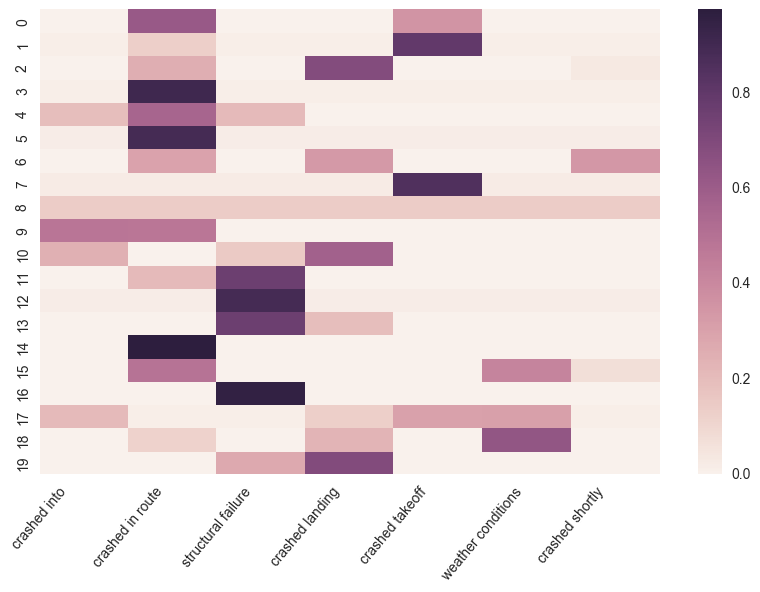

In [34]:
plt.figure(figsize=(10, 6))
seaborn.heatmap(compute_topic_summary_matrix(lda, corpus, df.Summary.values[:20]).transpose())
plt.xticks(range(8), summaries_topics, rotation=50, ha='center')